<a href="https://colab.research.google.com/github/Sergio-Rosales-Soria/DS-III/blob/main/Proyecto_Final_Sergio_Rosales_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

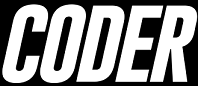

# Introducción
**Contexto empresarial**. En la era digital, la voz de los usuarios se ha convertido en un factor clave para la toma de decisiones en diversas industrias. Las opiniones expresadas en plataformas en línea, redes sociales y sitios web de reseñas proporcionan información valiosa sobre la percepción del público respecto a productos, servicios y experiencias. Sin embargo, interpretar esta gran cantidad de datos de manera eficiente requiere herramientas avanzadas que permitan extraer patrones y comprender el verdadero significado detrás de cada comentario.



**Contexto analitico** Este proyecto tiene como objetivo explorar el Análisis de Sentimientos a partir de un conjunto dea partir de un conjunto de datos de alta calidad, compuesto por aproximadamente 2,600 reseñas obtenidas de la plataforma Kaggle . A través del Procesamiento de Lenguaje Natural (PNL) , analizamos la estructura de los comentarios, identificando palabras clave, signos de puntuación y otros patrones lingüísticos que permiten clasificar los textos como positivos o negativos . Además, profundizaremos en las emociones subyacentes para obtener una visión más detallada de la experiencia del usuario.

Para llevar este análisis un paso más allá, implementaremos una Red Neuronal Recurrente (RNN) , entrenada con los datos recopilados, con el fin de desarrollar un modelo predictivo capaz de determinar automáticamente el sentimiento de nuevos comentarios . Esta metodología nos permitirá no solo clasificar opiniones, sino también entender la influencia de distintos factores en la percepción de los usuarios.

El presente estudio representa un esfuerzo por combinar técnicas avanzadas de PNL y aprendizaje profundo para extraer conocimiento útil a partir de datos textuales, con potenciales aplicaciones en áreas como marketing, atención al cliente y desarrollo de productos.

In [1]:
#librerias necesarias

import os
from collections import Counter

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd

from pylab import rcParams
from wordcloud import WordCloud
from nltk import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

rcParams['figure.figsize'] = 5, 3
%matplotlib inline

# Lectura de datos y analisis basico

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/My Drive/DS III/Proyecto Final/Datasets"
import os
print(os.getcwd())
os.chdir("/content/drive/My Drive/DS III/Proyecto Final/Datasets")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/DS III/Proyecto Final/Datasets
/content/drive/My Drive/DS III/Proyecto Final/Datasets


In [3]:
import pandas as pd
Twitter_1 = pd.read_csv('sentiment_analysis_dataset.csv')

Twitter_1.head()

,user,text,date,emotion,sentiment
0,@erreborda,termine bien abrumado después de hoy,"Jan 6, 2024 · 2:53 AM UTC",overwhelmed,scared
1,@shpiderduck,me siento abrumado,"Jan 6, 2024 · 2:35 AM UTC",overwhelmed,scared
2,@Alex_R_art,Me siento un poco abrumado por la cantidad de ...,"Jan 6, 2024 · 12:20 AM UTC",overwhelmed,scared
3,@anggelinaa97,Salvador la única persona que no la ha abrumad...,"Jan 5, 2024 · 10:38 PM UTC",overwhelmed,scared
4,@diegoreyesvqz,Denme un helado o algo que ando full abrumado.,"Jan 5, 2024 · 8:38 PM UTC",overwhelmed,scared


In [4]:
Twitter_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2590 entries, 0 to 2589
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   user       2590 non-null   object
 1   text       2590 non-null   object
 2   date       2590 non-null   object
 3   emotion    2590 non-null   object
 4   sentiment  2590 non-null   object
dtypes: object(5)
memory usage: 101.3+ KB


In [5]:
Twitter_1['text'] = Twitter_1['text'].astype('string')

In [6]:
#Vemos que todos los campos estan en formato "object".
#Transformaremos los campos con texto a formato "string", para poder trabajar mejor con herramientas de NLP.
Twitter_1['user'] = Twitter_1['user'].astype('string')
Twitter_1['text'] = Twitter_1['text'].astype('string')
Twitter_1['emotion'] = Twitter_1['emotion'].astype('string')
Twitter_1['sentiment'] = Twitter_1['sentiment'].astype('string')

In [7]:
Twitter_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2590 entries, 0 to 2589
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   user       2590 non-null   string
 1   text       2590 non-null   string
 2   date       2590 non-null   object
 3   emotion    2590 non-null   string
 4   sentiment  2590 non-null   string
dtypes: object(1), string(4)
memory usage: 101.3+ KB


In [8]:
Twitter_1.shape

(2590, 5)

Columnas del dataset:

- **user**: una referencia del usuario que dejo el review
- **Text**: la revisión escrita por el usuario
- **date**: fecha formato timestamp que indica cuando se creo la revision

- **emocion**: una referencia la emocion del usuario
- **sentimiento**: una referencia sobre el sentimiento del usuario


Miremos la distribucion del numero de palabras por review

Text(0, 0.5, 'Frecuencia')

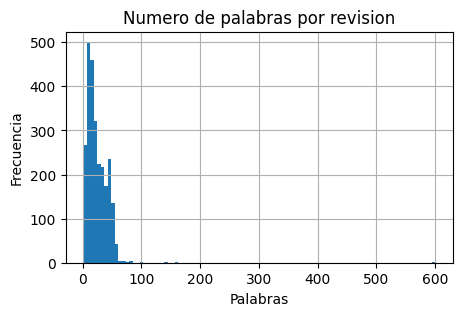

In [9]:
words_per_review = Twitter_1.text.apply(lambda x: len(x.split(" ")))
plt.figure(figsize=(5, 3))
words_per_review.hist(bins = 100)
plt.title('Numero de palabras por revision')
plt.xlabel('Palabras')
plt.ylabel('Frecuencia')

In [10]:
words_per_review.mean()

23.853281853281853

Distribucion de los ratings

In [11]:
Twitter_1.sentiment.value_counts()

,count
sentiment,
peaceful,660
mad,530
powerful,420
sad,360
joyful,350
scared,270


In [12]:
percent_val = 100 * Twitter_1.sentiment.value_counts()/Twitter_1.shape[0]
percent_val

,count
sentiment,
peaceful,25.482625
mad,20.46332
powerful,16.216216
sad,13.899614
joyful,13.513514
scared,10.42471


Text(0, 0.5, 'Porcentaje (%)')

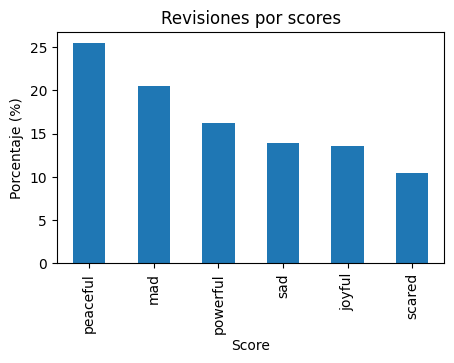

In [13]:
plt.figure(figsize=(5, 3))
percent_val.plot.bar()
plt.title('Revisiones por scores')
plt.xlabel('Score')
plt.ylabel('Porcentaje (%)')

# Wordcloud

In [14]:
Twitter_1.text
Twitter_1['text']

,text
0,termine bien abrumado después de hoy
1,me siento abrumado
2,Me siento un poco abrumado por la cantidad de ...
3,Salvador la única persona que no la ha abrumad...
4,Denme un helado o algo que ando full abrumado.
...,...
2585,No podemos vivir con miedo: ¡Manejen borrach...
2586,"La vida es un constante, SIN MIEDO AL ÉXITO 💅🏼"
2587,Esquizofrenia = mente dividida: Miedo a las re...
2588,"""Lo que más miedo me da, es ver cómo desaparec..."


344593


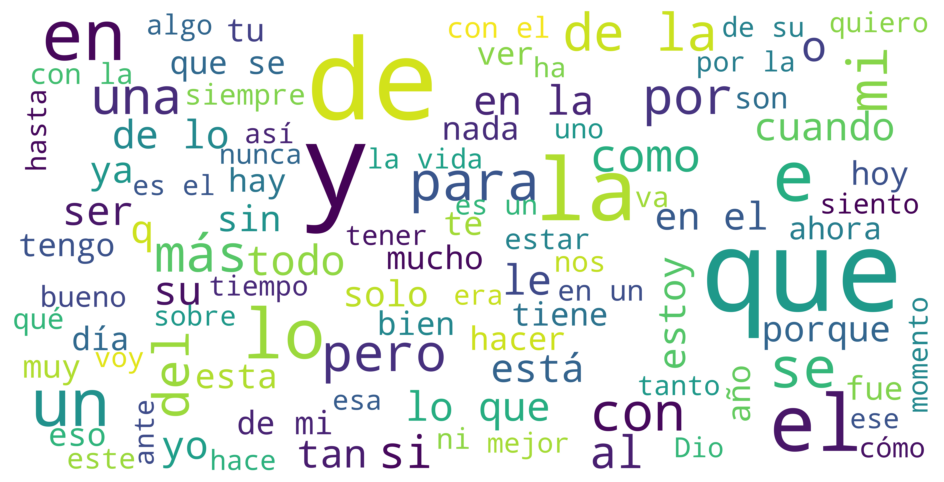

In [15]:
word_cloud_text = ''.join(Twitter_1.text)
print(len(word_cloud_text))

wordcloud = WordCloud(
    max_font_size=100,
    max_words=100,
    background_color="white",
    scale=10,
    width=800,
    height=400
).generate(word_cloud_text)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

El wordcloud muestra que las palabras que aparecen con mas frecuencia (de mayor tamaño) son palabras que podrian considerarse como stopwords. Lo cual sera un issue a tener en cuenta a la hora de realizar el preprosesamiento de datos.


# Estandarizacion binaria para analisis de sentimiento

Para propositos del analisis de sentimiento convertiremos todos los sentimientos en valores binarios con las siguientes reglas:
- sentimeintos "joyfull", "pacefull" y "powerfull"  seran convertidos a 1 (positivo)
- sentimientos "scared", "mad" y "sad" seran convertidos a 0 (negativo)


In [16]:
Twitter_1['Sentiment_rating'] = np.where(
    Twitter_1['sentiment'].isin(["peaceful", "powerful", "joyful"]), 1, 0
)


Twitter_1['Sentiment_rating'].value_counts()

,count
Sentiment_rating,
1,1430
0,1160


Text(0, 0.5, 'Frecuencia')

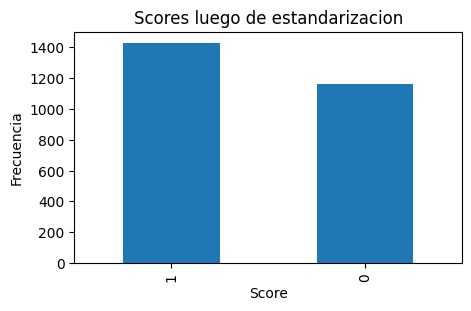

In [17]:

plt.figure(figsize=(5, 3))
Twitter_1.Sentiment_rating.value_counts().plot.bar()
plt.title('Scores luego de estandarizacion')
plt.xlabel('Score')
plt.ylabel('Frecuencia')

# Preprocesamiento

En este paso vamos a:
1. Convertir palabras a minusculas
2. remover caracteres especiales
3. remover stopwords y palabras de alta frecuencia
4. Stemming y lemantizacion

Procedamos con la primera fase

In [18]:
Twitter_1['reviews_text_new'] = Twitter_1.text.apply(lambda x: x.lower())

Las siguientes fases:

In [19]:
from nltk import word_tokenize
import nltk

nltk.download('punkt_tab')

token_lists = [word_tokenize(each) for each in Twitter_1.text]
tokens = [item for sublist in token_lists for item in sublist]
print("Numero de tokens unicos antes: ", len(set(tokens)))

token_lists_lower = [word_tokenize(each) for each in Twitter_1.reviews_text_new]
tokens_lower = [item for sublist in token_lists_lower for item in sublist]
print("Numero de tokens unicos nuevos: ", len(set(tokens_lower)))



[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Numero de tokens unicos antes:  12463
Numero de tokens unicos nuevos:  11241


In [20]:
(12463-11241)/12463

0.09805022867688358

El numero de tokens han bajado en cerca del 10% con la normalizacion

Eliminar caracteres especiales es una decisión compleja, especialmente en casos de analisis de sentimiento, la presencia de signos de exclamación puede indicar claramente algo sobre el sentimiento subyacente, por lo que eliminarlos puede no ser una buena idea.

Por otro lado, eliminar la puntuación sin carga emocional, como las comas, los puntos y el punto y coma, reducen diemencionalidad y no restan valor al modelo.

En aras de la simplicidad, procederemos eliminando todos los caracteres especiales; sin embargo, vale la pena tener en cuenta que esto es algo para revisar dependiendo de los resultados que obtengamos más adelante. Lo siguiente da una lista de todos los caracteres especiales en nuestro conjunto de datos

In [21]:
# Seleccionando los caracteres no alfa numericos que no son espacios
special_chars = Twitter_1.reviews_text_new.apply(lambda x: [each for each in list(x) if not each.isalnum() and each != ' '])

# obtener una lista de listas
flat_list = [item for sublist in special_chars for item in sublist]

# caracteres especiales unicos
print(set(flat_list))

{'🤒', '👏', '⚡', '🫠', '🙁', '●', '☕', '♎', '🤦', '😛', '🤷', '\xa0', '🥱', '🇱', '😋', '○', ']', '🚙', '/', '🔓', '💚', '━', '🎀', '🇵', '🚬', '◉', '💥', '🇺', '🌟', '❞', '🥶', '😘', '🤩', '🤭', '♀', '🌩', '\u200d', '¿', '💋', '💙', '💨', '🥴', '#', '\U0001fa75', '🇻', '🦌', '🇲', '🚌', '🎂', '🥀', '😆', '?', '💜', '🧵', '⃣', '☺', '‘', '😂', '😳', '👉', '🥹', '🇽', '🧠', '🏔', '✌', '&', '🧡', '🔱', '🕐', '🫤', '❓', '😻', '🥵', '🌈', '_', '–', '~', '•', '☹', '🦒', '🌚', '😌', '❌', '🚗', '>', '💔', '🇷', '🔥', '♂', '🥰', '✨', '🧑', '🍃', '🤢', '😔', '🐷', '💩', '🛐', '🤣', '🫵', '🛠', '😭', '🌊', '❤', '🍾', '😾', '🎵', '🏖', '😿', '🌌', '🇯', '💅', '🍳', '🌺', '🤪', '😣', '➖', '🐊', '⚙', '🕵', '"', '🥳', '🎸', '👍', '😮', '%', '°', '💛', '🫣', '📲', '🤡', '♒', '⏳', '🦸', '👊', '💭', '👁', '😬', '🎶', '🔋', '🙄', '💘', '💸', ')', '☠', '😊', '😍', '’', '🏳', '💖', '🚨', '🌹', '😉', '=', '🤍', '🤨', '🇭', '🪄', '🤠', '🇹', '👼', '💓', '✊', '👑', '➡', ',', '😩', '💁', '😓', '🥲', '🥃', '😒', '💊', '😈', '🪨', '͟', '😥', '😏', '💀', '😖', '😞', '⚠', '🖤', '😵', '🦕', '💕', '✅', '💗', '👣', '.', '🏿', '🫡', '-', '🐽', '🤗', '🎄', '(

Ahora removamos los caracteres especiales de los reviews

In [22]:
import re
review_backup = Twitter_1.reviews_text_new.copy()
Twitter_1.reviews_text_new = Twitter_1.reviews_text_new.apply(
    lambda x: re.sub('[^A-Za-z0-9 ]+', ' ', x)
)

Miremos como se ven algunos de los resultados luego de remover esto

In [23]:
print("Review anterior:")
review_backup.values[7]

Review anterior:


'oh, las vacaciones. tesoros inciertos, venideros y preciados para cualquier trabajador abrumado por la sobreexplotación. un sueño fugaz en el que el dinero parecía no importar, a cambio de un breve respiro de placer, diversión y alivio.  su tesoro perdido, ahora convertido'

In [24]:
print("Review nuevo:")
Twitter_1.reviews_text_new[7]

Review nuevo:


'oh  las vacaciones  tesoros inciertos  venideros y preciados para cualquier trabajador abrumado por la sobreexplotaci n  un sue o fugaz en el que el dinero parec a no importar  a cambio de un breve respiro de placer  diversi n y alivio   su tesoro perdido  ahora convertido'

El numero de tokens unicos que se han borrado son

In [25]:
token_lists = [word_tokenize(each) for each in Twitter_1.text]
tokens = [item for sublist in token_lists for item in sublist]
print("Numero de token unicos antes: ", len(set(tokens)))

token_lists = [word_tokenize(each) for each in Twitter_1.reviews_text_new]
tokens = [item for sublist in token_lists for item in sublist]
print("Numero de tokens unicos despues: ", len(set(tokens)))

Numero de token unicos antes:  12463
Numero de tokens unicos despues:  10205


## stopwords y palabras de alta/baja frecuencia

Vamos a remover estas palabras

In [26]:
import nltk
nltk.download('stopwords')

noise_words = []
stopwords_corpus = nltk.corpus.stopwords
es_stop_words = stopwords_corpus.words('spanish')
noise_words.extend(es_stop_words)
print(len(noise_words))
noise_words

313


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['de',
 'la',
 'que',
 'el',
 'en',
 'y',
 'a',
 'los',
 'del',
 'se',
 'las',
 'por',
 'un',
 'para',
 'con',
 'no',
 'una',
 'su',
 'al',
 'lo',
 'como',
 'más',
 'pero',
 'sus',
 'le',
 'ya',
 'o',
 'este',
 'sí',
 'porque',
 'esta',
 'entre',
 'cuando',
 'muy',
 'sin',
 'sobre',
 'también',
 'me',
 'hasta',
 'hay',
 'donde',
 'quien',
 'desde',
 'todo',
 'nos',
 'durante',
 'todos',
 'uno',
 'les',
 'ni',
 'contra',
 'otros',
 'ese',
 'eso',
 'ante',
 'ellos',
 'e',
 'esto',
 'mí',
 'antes',
 'algunos',
 'qué',
 'unos',
 'yo',
 'otro',
 'otras',
 'otra',
 'él',
 'tanto',
 'esa',
 'estos',
 'mucho',
 'quienes',
 'nada',
 'muchos',
 'cual',
 'poco',
 'ella',
 'estar',
 'estas',
 'algunas',
 'algo',
 'nosotros',
 'mi',
 'mis',
 'tú',
 'te',
 'ti',
 'tu',
 'tus',
 'ellas',
 'nosotras',
 'vosotros',
 'vosotras',
 'os',
 'mío',
 'mía',
 'míos',
 'mías',
 'tuyo',
 'tuya',
 'tuyos',
 'tuyas',
 'suyo',
 'suya',
 'suyos',
 'suyas',
 'nuestro',
 'nuestra',
 'nuestros',
 'nuestras',
 'vuestro'

Encontremos las palabras de alta y baja frecuencia, que definiremos como el 1 % de las palabras que aparecen con más frecuencia en las reseñas, así como el 1 % de las palabras que aparecen con menos frecuencia en las reseñas (después de ajustar por mayúsculas y minúsculas y caracteres especiales).

In [27]:
one_percentile = int(len(set(tokens)) * 0.01)
top_1_percentile = Counter(tokens).most_common(one_percentile)
top_1_percentile[:10]

[('de', 2515),
 ('que', 2145),
 ('a', 1973),
 ('y', 1778),
 ('la', 1481),
 ('el', 1310),
 ('no', 1114),
 ('en', 1082),
 ('me', 880),
 ('un', 825)]

Text(0, 0.5, 'Frecuencia')

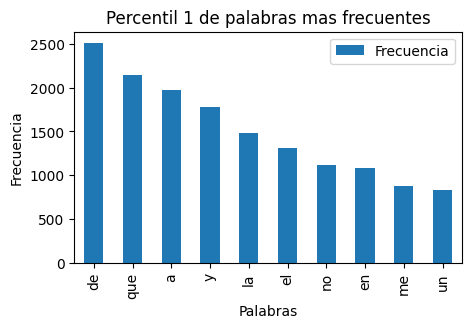

In [28]:
pd.DataFrame(top_1_percentile[:10], columns=['Palabras','Frecuencia']).set_index('Palabras').plot(kind='bar')
plt.title('Percentil 1 de palabras mas frecuentes')
plt.xlabel('Palabras')
plt.ylabel('Frecuencia')

In [29]:
bottom_1_percentile = Counter(tokens).most_common()[-one_percentile:]
bottom_1_percentile[:10]

[('propicio', 1),
 ('cifrar', 1),
 ('obrar', 1),
 ('justamente', 1),
 ('aurelio', 1),
 ('cimen', 1),
 ('ptico', 1),
 ('capcioso', 1),
 ('posee', 1),
 ('extraordinaria', 1)]

In [30]:
noise_words.extend([word for word,val in top_1_percentile])
noise_words.extend([word for word,val in bottom_1_percentile])

Las stopwords y las palabras de alta/baja frecuencia ahora se han agregado a noise_words, que se eliminarán de las revisiones antes de entrenar los modelos de aprendizaje automático.

Es poco probable que las stopwords sean tan útiles, ya que esperamos que aparezcan con la misma frecuencia en las críticas positivas y negativas. Las palabras poco comunes pueden ser más significativas y, en teoría, podrían indicar el sentimiento de la revisión

# Creacion de modelo de ML

In [31]:
Twitter_1[['text','sentiment','Sentiment_rating']].head(5)

,text,sentiment,Sentiment_rating
0,termine bien abrumado después de hoy,scared,0
1,me siento abrumado,scared,0
2,Me siento un poco abrumado por la cantidad de ...,scared,0
3,Salvador la única persona que no la ha abrumad...,scared,0
4,Denme un helado o algo que ando full abrumado.,scared,0


Las variables independientes o características del modelo se derivan del texto de revisión. Usaremos **n-grams** para crear características, y específicamente la bolsa de palabras como la interpretación más simple de estos n-gramas, sin tener en cuenta el orden y el contexto por completo y solo enfocándonos en la frecuencia/recuento. Usaremos eso como punto de partida.

# 1.- Bag of words

CountVectorizer es una clase de Python que da cuenta automáticamente de ciertos pasos de preprocesamiento, como la eliminación de palabras vacías, la derivación, la creación de n-gramas y la tokenización de palabras:

In [32]:
# Creacion de metodo para stemming
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()
analyzer = CountVectorizer().build_analyzer()

def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

Usemos esto para crear una bolsa de palabras de los twits, excluyendo las palabras irrelevantes que identificamos anteriormente. Para empezar usaremos ngrama (1,1):

In [33]:
# Creacion de un objeto tipo CountVectorizer
bow_counts = CountVectorizer(
    tokenizer=word_tokenize,
    stop_words=noise_words,
    ngram_range=(1, 1)
)

Una vez que se prepara la bolsa de palabras, el conjunto de datos debe dividirse en conjuntos de entrenamiento y de prueba. También podríamos dividir los datos después de vectorizarlos, pero es útil dividir los datos lo antes posible en el proceso. Esto significa que una vez que hemos generado nuestras predicciones, podemos compararlas más fácilmente con los textos originales, antes de que hayan sido preprocesadas y vectorizadas.

In [34]:
reviews_train, reviews_test = train_test_split(Twitter_1, test_size=0.2, random_state=0)

In [35]:
X_train_bow = bow_counts.fit_transform(reviews_train.reviews_text_new)
X_test_bow = bow_counts.transform(reviews_test.reviews_text_new)

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Llamamos a ```fit_transform``` para vectorizar nuestro conjunto de entrenamiento y ```transform``` para vectorizar nuestro conjunto de prueba. Esto genera las asignaciones de vectorización solo en los datos del conjunto de entrenamiento, que es una restricción a la que nos enfrentaremos.

Por lo tanto, puede haber algunas palabras en el conjunto de prueba que no sabemos cómo vectorizar y se omitirán.

In [36]:
y_train_bow = reviews_train['Sentiment_rating']
y_test_bow = reviews_test['Sentiment_rating']

In [37]:
y_test_bow.value_counts() / y_test_bow.shape[0]

,count
Sentiment_rating,
1,0.542471
0,0.457529


Los datos de prueba contienen 54% de comentarios con sentimientos positivos. En este caso, dicho modelo obtendría un 54 % de precisión, por lo que podemos considerarlo como una puntuación de referencia que nuestro modelo de aprendizaje automático debe superar.

## Modelo de regresion logistica

In [38]:
# Entrenar el modelo
lr_model_all = LogisticRegression(C=1, solver="liblinear")
lr_model_all.fit(X_train_bow, y_train_bow)

# Predecir el output
test_pred_lr_prob = lr_model_all.predict_proba(X_test_bow)
test_pred_lr_all = lr_model_all.predict(X_test_bow)

print("F1 score: ", f1_score(y_test_bow, test_pred_lr_all))
print("Accuracy: ", accuracy_score(y_test_bow, test_pred_lr_all) * 100)

F1 score:  0.928695652173913
Accuracy:  92.08494208494209


In [39]:
test_pred_lr_prob

array([[0.24704043, 0.75295957],
       [0.5534366 , 0.4465634 ],
       [0.18188769, 0.81811231],
       ...,
       [0.34695208, 0.65304792],
       [0.20609842, 0.79390158],
       [0.26351319, 0.73648681]])

In [40]:
probabilities = [each[1] for each in test_pred_lr_prob]

In [41]:
predictions = pd.DataFrame()
predictions['text'] = reviews_test['text']
predictions['Actual_Score'] = reviews_test['sentiment']
predictions['Sentiment_rating'] = reviews_test['Sentiment_rating']
predictions['Predicted_sentiment'] = test_pred_lr_all
predictions['Predicted_probability'] = probabilities

In [42]:
predictions.head(5)

,text,Actual_Score,Sentiment_rating,Predicted_sentiment,Predicted_probability
2401,"Aunque me genere incertidumbre el futuro, sé q...",joyful,1,1,0.752960
812,Escribo tweets a lo pendejo jajaja nobody care...,sad,0,0,0.446563
2528,3ro. Abres el 9no con Jermaine Palacios dando ...,joyful,1,1,0.818112
443,Permitid q haya espacios en vuestra unión Deja...,mad,0,1,0.601674
1857,e decidido cambiarme de user en mi priv…..solo...,powerful,1,1,0.834462


In [43]:
accuracy_score(predictions['Sentiment_rating'], predictions['Predicted_sentiment'])

0.9208494208494209

En la columna ```Predicted_probability```, se puede ver la confianza que tiene el modelo en sus predicciones, siendo las probabilidades muy cercanas a 0 predicciones de sentimientos negativos muy confiables y las probabilidades muy cercanas a 1, predicciones de sentimientos positivos muy confiables.

Inferimos que con la utilizacion de ngrama (1,1) y la supresion de palabras irrelevantes el modelo predice con un accuracy de 92%, lo que podria estar indicando overfitting.

In [44]:
predictions[
    predictions['Predicted_sentiment'] != predictions['Sentiment_rating']
].sort_values(by=["Predicted_probability"]).head(3)

,text,Actual_Score,Sentiment_rating,Predicted_sentiment,Predicted_probability
2554,"Aiga sido, como haiga sido, el gober quiere al...",joyful,1,0,0.068541
2551,¿Por qué no pedí perdón? si ya me es indiferen...,joyful,1,0,0.112382
1961,Hoy murió Carlos Bremer empresario Mexicano ex...,powerful,1,0,0.135340


In [45]:
predictions.loc[1961].values

array(['Hoy murió Carlos Bremer empresario Mexicano exitoso y visionario, siendo un ejemplo de lo que debe ser y  hacer un empresario, preocupado y apoyando a su personal y emprendiendo más negocios en conjunto con dueños de MiPYMES. México necesita empresarios cómo él y no explotadores.',
       'powerful', 1, 0, 0.13533970917053278], dtype=object)

Podemos ver que la reseña tiene un tono muy negativo, dado que empieza anunciando una muerte (generalmente relacionado con trizteza). Sin embargo, despues de anunciar su muertem hace un homenaje, diciendo que es un "ejemplo" y que se necesitan "empresarios como el". Sin embargo esto no es lo suficientemente fuerte como para contrarrestar el aspecto negativos del inicio de la reseña, Esto nos da un indicio de que quizas los encabezados o primeras palabras son las que mas pesan en el modelo a la hora de predecir sentimientos.

Modificaremos el conjunto de características en el modelo para incluir bigramas, trigramas y 4-grams, sin eliminar las palabras irrelevantes definidas anteriormente antes de presentarlas. (ngram_range=(1,4).)

Al mismo tiempo, ajsutaremos hiperparámetros.  (clasificador de regresión logística a 0,9.)

In [46]:
# Cambios con respecto al código anterior
# 1. Aumentar los n-gramas de solo tener 1 gramo a (1 gramo, 2 gramos, 3 gramos y 4 gramos)
# 2. Incluir las palabras vacías en las características de la bolsa de palabras
bow_counts = CountVectorizer(
    tokenizer=word_tokenize,
    ngram_range=(1,4)
)

X_train_bow = bow_counts.fit_transform(reviews_train.reviews_text_new)
X_test_bow = bow_counts.transform(reviews_test.reviews_text_new)

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [47]:
# Observamos el aumento de funciones con la inclusión de palabras vacías
X_train_bow

<2072x114285 sparse matrix of type '<class 'numpy.int64'>'
	with 182511 stored elements in Compressed Sparse Row format>

In [48]:
# Cambios en la regresión logística
# Cambio de la sanción de regularización por defecto de l2 a l1
# Cambiando el parámetro de costo C a 0.9
lr_model_all_new = LogisticRegression(C=0.9, solver="liblinear")

In [49]:
# Entrenar el modelo
lr_model_all_new.fit(X_train_bow, y_train_bow)

# Predecir resultados
test_pred_lr_prob = lr_model_all_new.predict_proba(X_test_bow)
test_pred_lr_all = lr_model_all_new.predict(X_test_bow)

print("F1 score: ", f1_score(y_test_bow, test_pred_lr_all))
print("Accuracy: ", accuracy_score(y_test_bow, test_pred_lr_all) * 100)

F1 score:  0.831973898858075
Accuracy:  80.11583011583011


La precisión ha saltado del 92% al 80%. Parametros mas razonables considerando que implementamos ngramas (1,4).

In [50]:
lr_weights = pd.DataFrame(list(
    zip(
        bow_counts.get_feature_names_out(),
        lr_model_all_new.coef_[0])
    ),
    columns=['words','weights']
)

lr_weights.sort_values(['weights'],ascending = False)[:15]

,words,weights
8526,anonadado,0.771507
7836,amo,0.698311
45006,grato,0.667494
12629,bueno,0.636296
94064,sensible,0.633323
18436,confiado,0.610668
93884,seguro,0.609710
10369,atrevido,0.591721
44951,gratificante,0.581850
13516,caloroso,0.578517


In [51]:
lr_weights.sort_values(['weights'],ascending = False)[-15:]

,words,weights
97500,soltero,-0.598701
62975,me siento,-0.626338
66084,molesto,-0.647908
43251,frustrado,-0.649363
28629,desilusionado,-0.672690
14852,celoso,-0.673099
40612,estoy,-0.689220
97751,sonrojado,-0.699379
77653,perdido,-0.721319
49612,impotente,-0.730422


# 2.- Modelo TF-IDF

Por supuesto, la bolsa de palabras no es la única forma de caracterizar el texto. Otro método, que mencionamos brevemente antes, es el método TF-IDF. Esto evalúa qué tan importante es una palabra para un documento dentro de una gran colección de documentos (es decir, corpus). La importancia aumenta proporcionalmente en función del número de veces que aparece una palabra en el documento, pero se compensa con la frecuencia de la palabra en el corpus.

La TF-IDF es el producto de dos términos. El primero calcula la frecuencia de término normalizada (TF); es decir, el número de veces que aparece una palabra en un documento dividido por el número total de palabras en ese documento. El segundo término es la Frecuencia Inversa de Documentos (IDF), calculada como el logaritmo del número de documentos en el corpus dividido por el número de documentos

Menos formalmente, ¿qué significa esto?

- Si una palabra aparece con mucha frecuencia en un documento específico, es probable que sea significativa.
- Si una palabra aparece con mucha frecuencia en casi todos los documentos del corpus, es poco probable que sea significativa.
- Por tanto, una palabra que aparece a menudo en un documento pero rara vez en el resto del corpus merece especial atención.

TF-IDF no solo cuenta cada palabra, sino que aplica una ponderación para que las palabras comunes reciban menos atención y las palabras raras reciban más.

Volvamos a presentar nuestro conjunto original de revisiones basado en TF-IDF y dividamos las funciones resultantes en conjuntos de entrenamiento y prueba:

In [52]:
# Cree un vectorizador: aún alimentamos nuestras stopwords, aunque
# estos son menos relevantes ahora ya que TF-IDF los ponderaría menos
# de todas formas.
tfidf_counts = TfidfVectorizer(
    tokenizer=word_tokenize,
    stop_words=noise_words,
    ngram_range=(1,1)
)

X_train_tfidf = tfidf_counts.fit_transform(reviews_train.reviews_text_new)
X_test_tfidf = tfidf_counts.transform(reviews_test.reviews_text_new)

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


## Regresion logistica con TF-IDF

In [53]:
# Crear el clasificador
lr_model_tf_idf = LogisticRegression(solver="liblinear")

# Entrenar
lr_model_tf_idf.fit(X_train_tfidf, y_train_bow)

# Predecir
test_pred_lr_prob = lr_model_tf_idf.predict_proba(X_test_tfidf)
test_pred_lr_all = lr_model_tf_idf.predict(X_test_tfidf)

## Evaluar el modelo
print("F1 score: ",f1_score(y_test_bow, test_pred_lr_all))
print("Accuracy: ", accuracy_score(y_test_bow, test_pred_lr_all) * 100)

F1 score:  0.8816855753646677
Accuracy:  85.9073359073359


Aquí hemos logrado una precisión del 85 % con TF-IDF en comparación con el 92 % con 1-gram. Es difícil saber exactamente por qué este algoritmo de vectorización más sofisticado conduce a peores resultados, pero podría ser que penalizar palabras que son comunes en todo el corpus genere una desventaja para este conjunto de datos en particular. TF-IDF suele ser útil cuando los datos de prueba son muy diferentes de los datos de entrenamiento, lo que permite que se desprioricen las palabras que solo son comunes en el conjunto de entrenamiento.

Trataremos de aumentar la precisión del modelo por

- configurando ```ngram_range=(1,4)``` en el Vectorizador
- no eliminar las palabras irrelevantes de antemano en el Vectorizador
- configurando C=10 en el clasificador LogisticRegression
- estableciendo penalización="l1" en el clasificador LogisticRegression

In [54]:
tfidf_counts = TfidfVectorizer(
    tokenizer=word_tokenize,
    ngram_range=(1,4)
)

X_train_tfidf = tfidf_counts.fit_transform(reviews_train.reviews_text_new)
X_test_tfidf = tfidf_counts.transform(reviews_test.reviews_text_new)

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [55]:
# definiendo la clase del modelo
lr_model_tf_idf_new = LogisticRegression(solver="liblinear", penalty='l1', C=10)

# Entrenar
lr_model_tf_idf_new.fit(X_train_tfidf, y_train_bow)

# Predecir
test_pred_lr_prob = lr_model_tf_idf_new.predict_proba(X_test_tfidf)
test_pred_lr_all = lr_model_tf_idf_new.predict(X_test_tfidf)

# Evaluar el modelo
print("F1 score: ",f1_score(y_test_bow, test_pred_lr_all))
print("Accuracy: ", accuracy_score(y_test_bow, test_pred_lr_all)*100)

F1 score:  0.9416058394160584
Accuracy:  93.82239382239382


Esta es una mejora con respecto a nuestro resultado anterior.

También podemos encontrar nuestras características más importantes nuevamente, como se muestra a continuación:

In [56]:
lr_weights = pd.DataFrame(
    list(
        zip(tfidf_counts.get_feature_names_out(), lr_model_tf_idf_new.coef_[0])
    ),
    columns=['words','weights']
)

lr_weights.sort_values(['weights'],ascending = False)[:10]

,words,weights
74157,optimista,15.522258
45006,grato,14.759128
44814,gracioso,14.229712
18436,confiado,13.793209
89696,resuelto,13.396026
18220,con una,13.121019
81313,positivo,13.030503
8471,animado,13.003343
88700,reconocimiento,12.730935
5725,agradecido,11.685673


In [57]:
lr_weights.sort_values(['weights'],ascending = False)[-10:]

,words,weights
77653,perdido,-34.030062
8854,apartado,-34.829710
5416,adormilado,-37.547842
28172,desbordante,-37.704285
41314,exasperado,-38.032343
4580,abrumado,-39.650169
28152,desbordado,-40.589023
97236,solitario,-41.019955
94339,separado,-41.516414
19188,contrariado,-41.641049


# Conclusiones

Los modelos de bag of words son muy buenos a la hora de identificar textos de polaridades claras pero le cuesta mucho cuando los textos presentan polaridades menos claras y caracteristicas mas complejas.

Para esto se utilizan modelos mas poderosos como TF.IDF y modelos de aprendizaje supervisado,

En este caso, limpiamos y destacamos un conjunto de datos de comentarios de Twitwer y construimos algunos modelos de clasificación en estas características para predecir el sentimiento. Vimos que la bolsa de palabras y TF-IDF brindaban características interpretables. Al aumentar el conjunto de n-gramas que usamos de 1-gram a 4-grams, nuestra presicion bajo para BOR, pero pudimos obtener la precisión de nuestro modelo de regresión logística hasta en un 94 % en TF-IDF.

# Implementación de un modelo de deep Learning


#### Prepro
Vamos a diseñar una red neuronal capaz de aprender si un texto es positivo o negativo (sentimiento). Para ello utilizaremos la codificacion binaria de "ranking de sentimiento" creada en el ejercicio de NLP, para que la red neuronal, que trabaja con valores numéricos preferentemente, sea capaz de entenderlo.



In [61]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Definir hiperparámetros
vocab_size = 5000  # Número máximo de palabras en el vocabulario
max_length = 100   # Longitud máxima de las secuencias
embedding_dim = 128  # Dimensión del embedding
batch_size = 64
num_classes = len(Twitter_1['Sentiment_rating'].unique())  # Número de clases

# Tokenizar y convertir texto en secuencias de enteros
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(Twitter_1['text'])
sequences = tokenizer.texts_to_sequences(Twitter_1['text'])

# Padding de secuencias
x_data = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

# Convertir etiquetas a tensor
y_data = torch.tensor(Twitter_1['Sentiment_rating'].values, dtype=torch.long)

# Dividir datos en entrenamiento y validación
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

# Convertir a tensores
x_train_tensor = torch.tensor(x_train, dtype=torch.long)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
x_val_tensor = torch.tensor(x_val, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

# Crear Dataset personalizado
class TwitterDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

# Cargar datos en DataLoader
train_dataset = TwitterDataset(x_train_tensor, y_train_tensor)
val_dataset = TwitterDataset(x_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Definir modelo con PyTorch
class SentimentRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes):
        super(SentimentRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=2,
                            bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)  # Multiplicamos por 2 por bidireccionalidad
        self.dropout = nn.Dropout(0.5)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = self.dropout(x[:, -1, :])  # Tomamos la última salida de LSTM
        x = self.fc(x)
        return self.softmax(x)

# Instanciar modelo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SentimentRNN(vocab_size, embedding_dim, hidden_dim=64, num_classes=num_classes)
model.to(device)

# Definir función de pérdida y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entrenar el modelo
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct_train = 0

    # Entrenamiento
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct_train += (outputs.argmax(1) == y_batch).sum().item()

    train_acc = correct_train / len(train_loader.dataset)

    # Evaluar en validación
    model.eval()
    correct_val = 0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            correct_val += (outputs.argmax(1) == y_batch).sum().item()

    val_acc = correct_val / len(val_loader.dataset)

    # 📢 **Imprimir métricas en cada epoch**
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {total_loss:.4f} - Train Acc: {train_acc:.4f} - Test Acc: {val_acc:.4f}")

print("Entrenamiento finalizado ✅")

<ipython-input-61-32115393a37e>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)
<ipython-input-61-32115393a37e>:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_val_tensor = torch.tensor(y_val, dtype=torch.long)


Epoch [1/10] - Loss: 22.7671 - Train Acc: 0.5425 - Test Acc: 0.5560
Epoch [2/10] - Loss: 22.7334 - Train Acc: 0.5512 - Test Acc: 0.5560
Epoch [3/10] - Loss: 22.7377 - Train Acc: 0.5516 - Test Acc: 0.5560
Epoch [4/10] - Loss: 22.7287 - Train Acc: 0.5516 - Test Acc: 0.5560
Epoch [5/10] - Loss: 22.7598 - Train Acc: 0.5516 - Test Acc: 0.5560
Epoch [6/10] - Loss: 22.7009 - Train Acc: 0.5516 - Test Acc: 0.5560
Epoch [7/10] - Loss: 22.7110 - Train Acc: 0.5516 - Test Acc: 0.5560
Epoch [8/10] - Loss: 22.7444 - Train Acc: 0.5516 - Test Acc: 0.5560
Epoch [9/10] - Loss: 22.7237 - Train Acc: 0.5516 - Test Acc: 0.5560
Epoch [10/10] - Loss: 22.7585 - Train Acc: 0.5507 - Test Acc: 0.5560
Entrenamiento finalizado ✅


Se realizaron las siguintes mejoras. Probamos:

✅ Aumentar las dimensiones del embeddind de 128 a 256
✅ Aumentar ls capacidad con 128 neuronas en LSTM y una capa extra de 128 neuronas en fc1.
✅ Usa ReLU en la capa oculta para mejorar la no linealidad.
✅ Añadir regularización con BatchNorm y Dropout.
✅ Usar una tasa de aprendizaje más baja (0.001) para mejorar la convergencia.



Epoch [1/10] - Loss: 0.7037 - Train Acc: 0.5236 - Test Acc: 0.5560
Epoch [2/10] - Loss: 0.7021 - Train Acc: 0.5111 - Test Acc: 0.5560
Epoch [3/10] - Loss: 0.7019 - Train Acc: 0.5159 - Test Acc: 0.4440
Epoch [4/10] - Loss: 0.6959 - Train Acc: 0.5154 - Test Acc: 0.5560
Epoch [5/10] - Loss: 0.6979 - Train Acc: 0.5285 - Test Acc: 0.5560
Epoch [6/10] - Loss: 0.6922 - Train Acc: 0.5323 - Test Acc: 0.5560
Epoch [7/10] - Loss: 0.6964 - Train Acc: 0.5251 - Test Acc: 0.5560
Epoch [8/10] - Loss: 0.6937 - Train Acc: 0.5381 - Test Acc: 0.5560
Epoch [9/10] - Loss: 0.6936 - Train Acc: 0.5391 - Test Acc: 0.5560
Epoch [10/10] - Loss: 0.6917 - Train Acc: 0.5386 - Test Acc: 0.5560


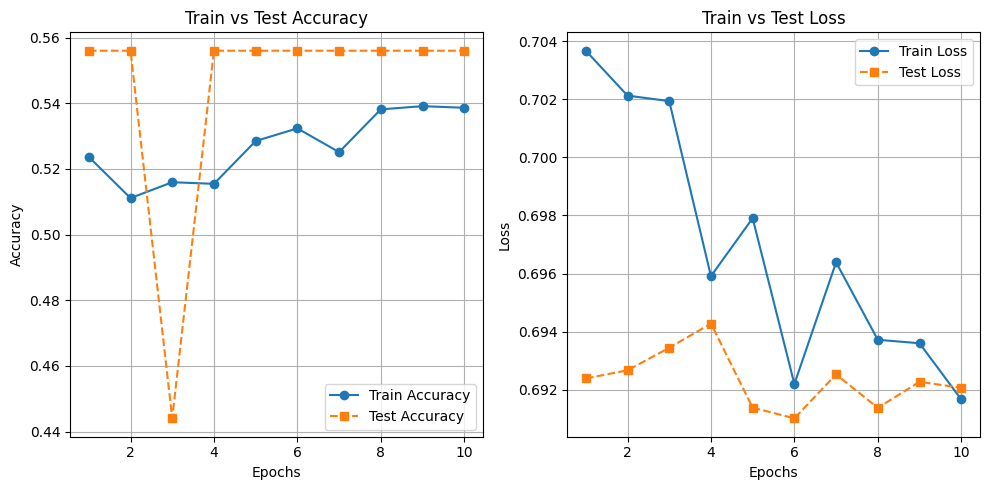

In [62]:
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Definir modelo mejorado con más capas y regularización
class ImprovedSentimentRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes):
        super(ImprovedSentimentRNN, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.batch_norm1 = nn.BatchNorm1d(embedding_dim)

        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=3,
                            bidirectional=True, batch_first=True, dropout=0.3)

        self.fc1 = nn.Linear(hidden_dim * 2, 128)  # Capa oculta adicional
        self.fc2 = nn.Linear(128, num_classes)  # Capa final de salida

        self.dropout = nn.Dropout(0.3)
        self.batch_norm2 = nn.BatchNorm1d(128)

    def forward(self, x):
        x = self.embedding(x)
        x = self.batch_norm1(x.permute(0, 2, 1)).permute(0, 2, 1)

        x, _ = self.lstm(x)
        x = self.dropout(x[:, -1, :])  # Última salida de LSTM

        x = self.fc1(x)
        x = F.relu(x)  # Activación ReLU
        x = self.batch_norm2(x)
        x = self.dropout(x)

        x = self.fc2(x)
        return F.softmax(x, dim=1)

# Instanciar modelo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ImprovedSentimentRNN(vocab_size, embedding_dim=256, hidden_dim=128, num_classes=num_classes)
model.to(device)

# Definir función de pérdida y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Reducción de tasa de aprendizaje

# Entrenar el modelo
num_epochs = 10
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    total_loss, correct_train = 0, 0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct_train += (outputs.argmax(1) == y_batch).sum().item()

    train_loss = total_loss / len(train_loader)
    train_acc = correct_train / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Evaluar en validación
    model.eval()
    total_loss, correct_val = 0, 0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            total_loss += loss.item()
            correct_val += (outputs.argmax(1) == y_batch).sum().item()

    val_loss = total_loss / len(val_loader)
    val_acc = correct_val / len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {train_loss:.4f} - Train Acc: {train_acc:.4f} - Test Acc: {val_acc:.4f}")

# Graficar resultados
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy', marker='o')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Test Accuracy', marker='s', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Test Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, num_epochs + 1), val_losses, label='Test Loss', marker='s', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Test Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

#Conclusion Final

Estancamiento del aprendizaje:

Se observa que la precisión en entrenamiento y prueba no mejora significativamente después de la primera época, incluiso despues de las mejoras implementadas.

La pérdida (Loss) fluctúa levemente, lo que indica que la red no está aprendiendo de manera efectiva.

Posible subajuste (underfitting):

La precisión de entrenamiento y prueba se mantiene alrededor del 55%, lo que sugiere que el modelo no está capturando patrones significativos en los datos.

Esto podría deberse al tamaño del dataset o insuficiente entrenamiento.

La precisión en prueba es constante (55.6%), lo que sugiere que el modelo puede estar prediciendo la misma clase para todas las muestras o que los datos no tienen suficiente variabilidad informativa.

Para estos casos funcionan de mejor manera los algortimos de Machine Lerning que los de Deep Learning